In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data & Import

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(DEVICE)

device = torch.device("cpu")

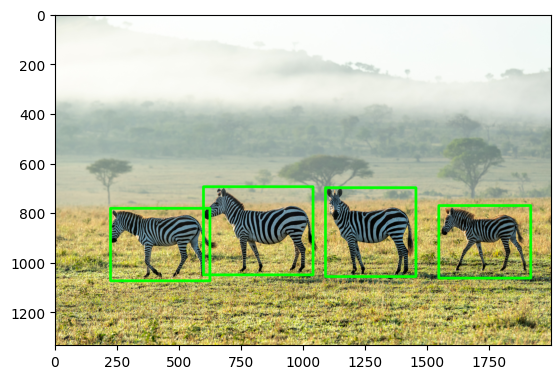

In [3]:
img0 = cv2.imread("/content/drive/MyDrive/Implement/Faster_R-CNN/zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

# object information : a set of bounding boxes [x1, y1, x2, y2]
# and their labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050],
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]])
labels = np.array([1, 1, 1, 1])     # 0: background, 1: zebra

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]),
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

(800, 800, 3)


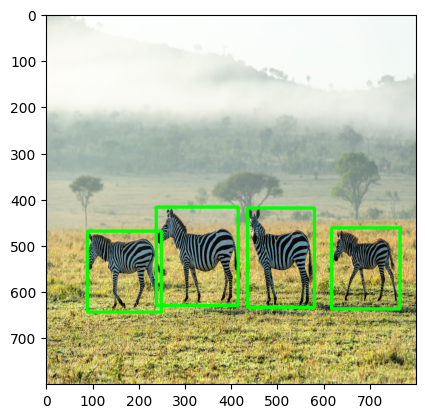

In [4]:
# change the bounding box coordinates
# original image size : (1333, 2000)
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
print(img.shape)

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)

bbox = np.array(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [5]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()
dummy_img.size(2)

800

## Confgs

In [114]:
in_channels = 512
rpn_out_channels = 512
n_anchor = 9
n_batch = 256

feature_size = 50

img_size = (800, 800)
min_size = 16

nms_thresh = 0.6
n_train_pre_nms = 12000
n_train_post_nms = 3000
n_test_post_nms = 300

n_sample = 128       # number of samples from roi
pos_ratio = 0.25          # number of positive examples out of the n_samples
pos_iou_thresh = 0.5          # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5         # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

frcnn_out_channels = 4096
lamda = 10

# **Faster R-CNN**

<img src="https://github.com/SuminizZ/Algorithm/assets/92680829/80920e06-339c-4d46-a492-1227b44b7fa8" width="850">

## Feature Extractor : VGG-16

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self, device):
        super(FeatureExtractor, self).__init__()

        model = torchvision.models.vgg16(pretrained=True).to(device)
        features = list(model.features)

        dummy = torch.zeros((1, 3, 800, 800)).float()    # test image array
        req_features = []
        dummy = dummy.to(device)

        for feature in features:
            dummy = feature(dummy)
            if dummy.size(2) < 800//16:     # 800/16=50
                break
            req_features.append(feature)
            out_channels = dummy.size(1)

        self.feature_extractor = nn.Sequential(*req_features)

    def forward(self, x):
        return self.feature_extractor(x)

## Anchor Generation Layer

In [8]:
# sub-sampling rate = 1/16
# image size : 800 x 800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes with varying scales and ratios
# total anchor boxes = 50 x 50 x 9 = 22500

def generate_anchors(feature_size):
    ctr = torch.empty((feature_size**2, 2))
    ctr_x = torch.arange(16, (feature_size + 1) * 16, 16)
    ctr_y = torch.arange(16, (feature_size + 1) * 16, 16)

    anc = 0
    for x in ctr_x:
        for y in ctr_y:
            ctr[anc, 0] = x - 8
            ctr[anc, 1] = y - 8
            anc += 1

    ratios = [0.5, 1, 2]
    scales = [8, 16, 32]
    combs = [(r, s) for r in ratios for s in scales]
    base_size = 8

    i = 0
    anchor_boxes = torch.empty((feature_size**2*9, 4))
    for x, y in ctr:
        for z in combs:
            ratio, scale = z
            w = scale*base_size*np.sqrt(ratio)
            h = scale*base_size*(1/np.sqrt(ratio))
            anchor_boxes[i] = torch.Tensor([x-w, y-h, x+w, y+h])
            i += 1

    return anchor_boxes

In [9]:
def select_valid_anchors(anchor_boxes):
    valid_idxs = np.where((anchor_boxes[:,0] >= 0) &
                          (anchor_boxes[:,1] >= 0) &
                          (anchor_boxes[:,2] <= 800) &
                          (anchor_boxes[:,3] <= 800))[0]
    valid_anchors = anchor_boxes[valid_idxs]
    return valid_idxs, valid_anchors

## Compute IoU with Ground-Truth Boxes

In [10]:
def get_IoUs(bbox, valid_anchors):
    ious = torch.ones((len(valid_anchors), bbox.shape[0]))*-1

    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = box
        ax1, ay1, ax2, ay2 = valid_anchors[:, 0], valid_anchors[:, 1], valid_anchors[:, 2], valid_anchors[:, 3]
        max_x1 = np.maximum(ax1, x1)
        max_y1 = np.maximum(ay1, y1)
        min_x2 = np.minimum(ax2, x2)
        min_y2 = np.minimum(ay2, y2)

        idxs = np.where((max_x1 < min_x2) & (max_y1 < min_y2))[0]
        tot_area = (ax2[idxs] - ax1[idxs])*(ay2[idxs] - ay1[idxs]) + (x2-x1)*(y2-y1)
        overlapped_area = (min_x2[idxs] - max_x1[idxs])*(min_y2[idxs] - max_y1[idxs])
        ious[idxs, i] =  overlapped_area / (tot_area - overlapped_area)

    # print(ious[8930:8940, :])
    return ious

## Get Lables and Parameterized Coordinates of Anchors

In [11]:
# 1 if
## 1. anchors with highest IoU with each ground truth box
## 2. IoU with respect to gt boxes higher than 0.7
# 0 if IoU less than 0.3

def get_anchor_labels(ious, valid_anchors):
    labels = torch.ones(len(ious))*-1

    max_iou_idxs = ious.argmax(axis=0)
    max_iou = ious[max_iou_idxs, torch.arange(ious.shape[1])] - 0.01
    print(max_iou)
    labels[np.where(ious >= max_iou)[0]] = 1
    print(np.where(ious >= max_iou)[0])

    max_iou_gtb_idxs = ious.argmax(axis=1)
    max_iou_gtb_vals = ious[torch.arange(len(max_iou_gtb_idxs)), max_iou_gtb_idxs]

    pos_label_threshold = 0.65
    neg_label_threshold = 0.3

    labels[max_iou_gtb_vals >=  pos_label_threshold] = 1
    labels[max_iou_gtb_vals <  neg_label_threshold] = 0

    max_iou_bbox = bbox[max_iou_gtb_idxs]

    n_sample = 256
    pos_ratio = 0.5
    n_pos = pos_ratio * n_sample

    pos_index = np.where(labels == 1)[0]
    print(len(pos_index))
    if len(pos_index) > n_pos:
        disable_index = np.random.choice(pos_index,
                                        size = (len(pos_index) - n_pos),
                                        replace=False)
        labels[disable_index] = -1

    return labels

In [12]:
# parameterizes the 4 coordinates of anchor boxes with each one's closest ground-truth boxe

def get_anchor_regs(ious, valid_anchors, bbox):
    bbox = torch.Tensor(bbox)

    max_iou_gt_idxs = ious.argmax(axis=1)
    gt_locs = bbox[max_iou_gt_idxs]

    w, h = (gt_locs[:, 2] - gt_locs[:, 0]), (gt_locs[:, 3] - gt_locs[:, 1])
    ctr_x, ctr_y = gt_locs[:, 0] + w*0.5, gt_locs[:, 1] + h*0.5

    wa, ha = (valid_anchors[:, 2] - valid_anchors[:, 0]), (valid_anchors[:, 3] - valid_anchors[:, 1])
    ctr_xa, ctr_ya = valid_anchors[:, 0] + wa*0.5, valid_anchors[:, 1] + ha*0.5

    eps = torch.finfo(w.dtype).eps
    w, h, wa, ha = np.maximum(w, eps), np.maximum(h, eps), np.maximum(wa, eps), np.maximum(ha, eps)

    dx, dy = (ctr_x - ctr_xa)/wa, (ctr_y - ctr_ya)/ha
    dw, dh = torch.log(w/wa), torch.log(h/ha)

    gt_regs = torch.cat([dx.unsqueeze(1), dy.unsqueeze(1), dw.unsqueeze(1), dh.unsqueeze(1)], dim=1)
    return gt_regs

## Region Proposal Networks (RPN)

In [13]:
class RPN(nn.Module):
    def __init__(self, n_anchor, in_channels, out_channels):
        super(RPN, self).__init__()

        # classifier (whether an anchor contains an object or not)
        self.classifier = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                                        nn.Conv2d(out_channels, n_anchor * 2, 1, 1, 0))

        # bounding box regressor (parameterized coordinates)
        self.regressor = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                                       nn.Conv2d(out_channels, n_anchor * 4, 1, 1, 0))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        class_scores = self.classifier(x)
        anchor_regs = self.regressor(x)

        return class_scores, anchor_regs

## Multi-Task Loss

In [173]:
def multi_task_loss(pred_clss_scores, gt_labels, pred_regs, gt_regs, lamda, use_pos_mask):
    # classification loss
    L_clss = F.cross_entropy(pred_clss_scores, gt_labels.long(), ignore_index=-1)  # normalized with batch size

    pos_idxs = np.where(gt_labels == 1)[0]
    # regression loss is activated only for positive anchors (ground-truth)
    if use_pos_mask:
        pos_mask = torch.zeros_like(pred_regs)
        pos_mask[pos_idxs] = 1
        pred_regs *= pos_mask
        gt_regs *= pos_mask

    # smooth L1
    dreg = torch.abs(pred_regs - gt_regs)
    beta = 1
    L_reg = ((dreg < beta).float() * 0.5 * dreg ** 2) + ((dreg >= beta).float() * (dreg - 0.5))
    N_reg = len(pos_idxs)

    mtl = L_clss + lamda*(L_reg.sum()/N_reg)

    print(f"Classification Error : {L_clss}  Regression Error : {L_reg.sum()/N_reg}")
    return mtl

## Proposal Layer : NMS

In [52]:
def non_maximum_supp(pred_regs, objectness_scores, anchor_boxes, img_size, min_size, n_pre_nms, n_post_nms, nms_thresh):
    ha = anchor_boxes[:, 3] - anchor_boxes[:, 1]
    wa = anchor_boxes[:, 2] - anchor_boxes[:, 0]
    ctr_ya = anchor_boxes[:, 1] + 0.5 * ha
    ctr_xa = anchor_boxes[:, 0] + 0.5 * wa

    dx = pred_regs[:, 0]
    dy = pred_regs[:, 1]
    dw = pred_regs[:, 2]
    dh = pred_regs[:, 3]

    ctr_x, ctr_y = dx*wa + ctr_xa, dy*ha + ctr_ya
    w, h = torch.exp(dw)*wa, torch.exp(dh)*ha

    roi = torch.zeros_like(pred_regs, dtype=pred_regs.dtype)
    roi[:, 0], roi[:, 1], roi[:, 2], roi[:, 3] = ctr_x - w*0.5, ctr_y - h*0.5, ctr_x + w*0.5, ctr_y + h*0.5

    # clipping the min & max of roi to img size
    roi[:, [0, 2]] = torch.clip(roi[:, [0, 2]], 0, img_size[0])
    roi[:, [1, 3]] = torch.clip(roi[:, [1, 3]], 0, img_size[1])

    hs = roi[:, 3] - roi[:, 1]
    ws = roi[:, 2] - roi[:, 0]

    keep = np.where((hs >= min_size) & (ws >= min_size))[0]
    roi, scores = roi[keep], objectness_scores[keep]

    order_idxs = scores.ravel().argsort(descending=True)[:n_pre_nms]
    print(order_idxs)
    roi, scores = roi[order_idxs], scores[order_idxs]

    keep = []
    x1, y1, x2, y2 = roi[:, 0], roi[:, 1], roi[:, 2], roi[:, 3]
    areas = (x2 - x1 + 1)*(y2 - y1 + 1)    # area of each anchor

    order_idxs = order_idxs.argsort(descending=True)
    while (order_idxs.size(0) > 0):
        i = order_idxs[0]
        keep.append(i)

        max_x1 = torch.maximum(x1[i], x1[order_idxs[1:]])
        max_y1 = torch.maximum(y1[i], y1[order_idxs[1:]])
        min_x2 = torch.minimum(x2[i], x2[order_idxs[1:]])
        min_y2 = torch.minimum(y2[i], y2[order_idxs[1:]])

        inter = torch.maximum(torch.tensor(0.), min_x2 - max_x1 + 1) * torch.maximum(torch.tensor(0.), min_x2 - max_x1 + 1)

        ious = inter / (areas[i] + areas[order_idxs[1:]] - inter)
        keep_idxs = np.where(ious <= nms_thresh)[0]
        order_idxs = order_idxs[keep_idxs+1]

    keep = keep[:n_post_nms]
    roi = roi[keep]

    return roi

## Proposal Target Layer

- Select samples from region proposals that are mostly useful for training the fast R-CNN.

In [16]:
def proposal_target_layer(roi, bbox, n_sample, pos_ratio, pos_iou_thresh):
    ious = torch.ones_like(roi)*-1

    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = box
        ax1, ay1, ax2, ay2 = roi[:, 0], roi[:, 1], roi[:, 2], roi[:, 3]
        max_x1 = torch.maximum(ax1, torch.tensor(x1))
        max_y1 = torch.maximum(ay1, torch.tensor(y1))
        min_x2 = torch.minimum(ax2, torch.tensor(x2))
        min_y2 = torch.minimum(ay2, torch.tensor(y2))

        idxs = np.where((max_x1 < min_x2) & (max_y1 < min_y2))[0]
        tot_area = (ax2[idxs] - ax1[idxs])*(ay2[idxs] - ay1[idxs]) + (x2-x1)*(y2-y1)
        inter_area = (min_x2[idxs] - max_x1[idxs])*(min_y2[idxs] - max_y1[idxs])
        ious[idxs, i] =  inter_area / (tot_area - inter_area)

    max_iou_gt_idxs = ious.argmax(dim=1)
    max_iou_gt_vals = ious[torch.arange(roi.size(0)), max_iou_gt_idxs]

    # select positive samples
    pos_roi_per_image = n_sample * pos_ratio
    pos_idxs = np.where(max_iou_gt_vals >= pos_iou_thresh)[0]
    pos_roi_per_this_image = int(min(pos_roi_per_image, pos_idxs.size))

    if len(pos_idxs) > 0:
        pos_idxs = np.random.choice(pos_idxs, size=pos_roi_per_this_image, replace=False)

    # select negtative (backgroud) samples
    neg_idxs = np.where((max_iou_gt_vals < pos_iou_thresh) &
                        (max_iou_gt_vals >= 0))[0]
    neg_roi_per_this_image = n_sample - pos_roi_per_this_image
    neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_idxs.size))

    if neg_idxs.size > 0:
        neg_idxs = np.random.choice(neg_idxs, size = neg_roi_per_this_image, replace=False)

    return ious, pos_idxs, neg_idxs

## RoI Ground Truth Labels & Locs

In [91]:
def ground_truth_rois(rois, bbox, pos_idxs, neg_idxs):
    keep_idxs = torch.Tensor(np.append(pos_idxs, neg_idxs)).long()

    gt_roi_labels = torch.zeros(len(keep_idxs))
    gt_roi_labels[:len(pos_idxs)] = 1

    sroi = rois[keep_idxs]    # sample roi extracted from proposal target layers
    bbox_sroi = bbox[ious.argmax(axis=1)[keep_idxs]]

    eps = torch.finfo(sroi.dtype).eps

    # sampled roi (pred)
    w = torch.maximum(sroi[:, 2] - sroi[:, 0], torch.tensor(eps))
    h = torch.maximum(sroi[:, 3] - sroi[:, 1], torch.tensor(eps))
    ctr_x = sroi[:, 0] + 0.5 * w
    ctr_y = sroi[:, 1] + 0.5 * h

    gt_w = bbox_sroi[:, 2] - bbox_sroi[:, 0]
    gt_h = bbox_sroi[:, 3] - bbox_sroi[:, 1]
    gt_ctr_x = bbox_sroi[:, 0] + 0.5 * gt_w
    gt_ctr_y = bbox_sroi[:, 1] + 0.5 * gt_h

    dx = (gt_ctr_x - ctr_x) / w
    dy = (gt_ctr_y - ctr_y) / h
    dw = torch.log(gt_w / w)
    dh = torch.log(gt_h / h)

    gt_roi_regs = torch.cat([dx.unsqueeze(1), dy.unsqueeze(1), dw.unsqueeze(1), dh.unsqueeze(1)], dim=1)

    return gt_roi_labels, gt_roi_regs

## RoI Pooling

In [119]:
# get img feature maps at predicted coordinates

def roi_pooling(rois, pos_idxs, neg_idxs, output_map):
    keep_idxs = np.append(pos_idxs, neg_idxs)
    gt_roi_labels = torch.ones(len(keep_idxs))
    gt_roi_labels[len(pos_idxs):] = 0
    sample_rois = rois[keep_idxs]

    admaxpool = nn.AdaptiveMaxPool2d((7,7), True)

    output = []
    rois = sample_rois*(1/16)    # sub-sampling ratio
    rois = rois[:, [1, 0, 3, 2]]
    rois = rois.long()

    for i in range(len(rois)):
        roi = rois[i]
        im = output_map.narrow(0, 0, 1)[..., roi[0]:(roi[2]+1), roi[1]:(roi[3]+1)]   # i : channel indexing
        tmp = admaxpool(im)
        output.append(tmp[0])

    output = torch.cat(output, 0)
    print(f"roi pooling output size : {output.size()}")
    k = output.view(output.size(0), -1)   # 128 x (512*7*7 = 25088)

    return k

## Fast R-CNN

In [44]:
class FastRCNN(nn.Module):
    def __init__(self, k, out_channels):
        super(FastRCNN, self).__init__()
        num_rois, in_channels = k.shape[0], k.shape[1]
        self.base = nn.Sequential(nn.Linear(in_channels, out_channels),
                                            nn.Linear(out_channels, out_channels//2))
        self.roi_regs = nn.Linear(out_channels//2, 8)    # 8 : 1 class, 1 background, 4 coordiinates
        self.roi_clss = nn.Linear(out_channels//2, 2)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base(x)
        pred_roi_regs = self.roi_regs(x)
        pred_roi_clss = self.roi_clss(x)

        return pred_roi_regs, pred_roi_clss

(128,) (23,) (105,)


# Forward Pass

In [146]:
anchor_boxes = generate_anchors(feature_size)
valid_idxs, valid_anchors = select_valid_anchors(anchor_boxes)

gt_ious = get_IoUs(bbox, valid_anchors)
gt_labels = get_anchor_labels(gt_ious, valid_anchors)
gt_regs = get_anchor_regs(gt_ious, valid_anchors, bbox)

tensor([0.5751, 0.5653, 0.5155, 0.6226])
[ 823  828  833 1009 1014 1019 1226 1232 1238 2862 2869 2876 3108 3115
 3122 3331 3338 3345 3352 3354 3359 3361 3366 3368 3373 3379 3385 3391
 3600 3607 3614 3846 3853 3860 5930 5937 6164 6171 6176 6178 6183 6185
 6192 6198 6422 6429 8548 8552 8556 8700 8704 8708]
52


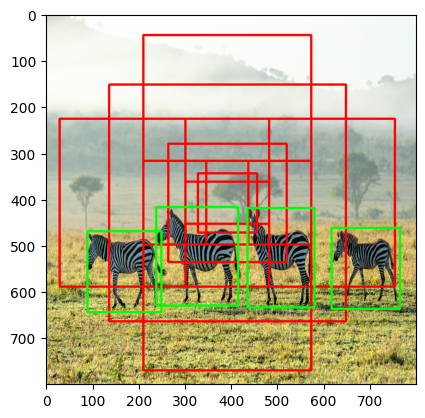

In [147]:
# display the anchor boxes of one anchor and the ground truth boxes
img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])

    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]),
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

In [148]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)

feature_extractor = FeatureExtractor(device)
output_map = feature_extractor(imgTensor)   # 1 x 512 x 50 x 50

rpn_layer = RPN(n_anchor, in_channels, rpn_out_channels)
pred_clss_scores, pred_regs = rpn_layer(output_map)

In [149]:
pred_clss_scores = pred_clss_scores.permute(0, 2, 3, 1).contiguous().view(1, -1, 2)
objectness_scores = pred_clss_scores[0][:, 1]
pred_regs = pred_regs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)

gt_anchor_labels = torch.ones((len(anchor_boxes),), dtype=gt_labels.dtype)*-1
gt_anchor_labels[valid_idxs] = gt_labels
gt_anchor_regs = torch.zeros_like(anchor_boxes)
gt_anchor_regs[valid_idxs] = gt_regs

In [150]:
print(output_map.shape)
print(pred_regs.shape)
print(pred_clss_scores.shape)
print(objectness_scores.shape)
print(gt_anchor_labels.shape)
print(gt_anchor_regs.shape)

torch.Size([1, 512, 50, 50])
torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
torch.Size([22500])
torch.Size([22500])
torch.Size([22500, 4])


In [152]:
n_batch = len(pred_regs)
mlt_loss = 0
for i in range(n_batch):
    mlt_loss += multi_task_loss(pred_clss_scores[i], gt_anchor_labels, pred_regs[i], gt_anchor_regs, 10, True)

mlt_loss

tensor(2.0671, grad_fn=<AddBackward0>)

In [153]:
rois = non_maximum_supp(pred_regs[0], objectness_scores, anchor_boxes, img_size, min_size, n_train_pre_nms, n_train_post_nms, nms_thresh)
rois.shape

ious, pos_idxs, neg_idxs = proposal_target_layer(rois, bbox, n_sample, pos_ratio, pos_iou_thresh)
print(np.append(pos_idxs, neg_idxs).shape, pos_idxs.shape, neg_idxs.shape)

tensor([16157, 16463, 13295,  ..., 10158,  8350,  7924])
(128,) (17,) (111,)


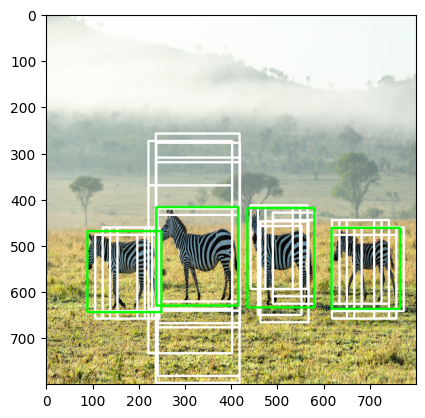

In [139]:
img_clone = np.copy(img)
rois_numpy = rois.detach().numpy()

for i in range(len(pos_idxs)):
  x1, y1, x2, y2 = rois_numpy[pos_idxs[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)

for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]),
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

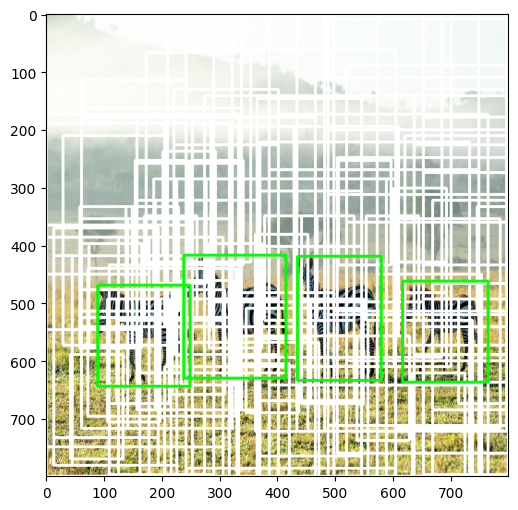

In [40]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(len(neg_idxs)):
  x1, y1, x2, y2 = rois_numpy[neg_idxs[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)

for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]),
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

### Here

In [174]:
gt_roi_labels, gt_roi_regs = ground_truth_rois(rois, torch.Tensor(bbox), pos_idxs, neg_idxs)
k = roi_pooling(rois, pos_idxs, neg_idxs, output_map)
model = FastRCNN(k, frcnn_out_channels)
pred_roi_regs, pred_roi_clss = model(k)

print(gt_roi_regs.shape, gt_roi_labels.shape)
print(pred_roi_regs.shape, pred_roi_clss.shape)

roi pooling output size : torch.Size([128, 512, 7, 7])
torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 8]) torch.Size([128, 2])


In [175]:
pred_roi_regs = pred_roi_regs.view(n_sample, -1, 4)
pred_roi_regs = pred_roi_regs[torch.arange(0, n_sample).long(), gt_roi_labels.long()]
mtl = multi_task_loss(pred_roi_clss, gt_roi_labels, pred_roi_regs, gt_roi_regs, lamda, False)
print(f"Multi Task Loss : {mtl}")

Classification Error : 0.5399757623672485  Regression Error : 7.073288917541504
Multi Task Loss : 71.27286529541016
